# Carbon Emission Forecast

### Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import matplotlib.colors as mcolors

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import requests
from io import BytesIO

### Data Reading

In [2]:
URL = "https://raw.githubusercontent.com/thiagoneye/project-ccus_analysis/main/data/Registro%20P%C3%BAblico%20de%20Emiss%C3%B5es.xlsx"
response = requests.get(URL)
df = pd.read_excel(BytesIO(response.content), engine="openpyxl")

# Data Processing

df = df[df["Escopo"] == "Escopo 1"]
df.drop(columns=["Setor da Indústria", "Escopo"], inplace=True)

df = df.transpose()
df.columns = df.iloc[0]
df = df[1:].reset_index()
df = df.rename(columns={"index": "Years"})

# Company Names

dict_company_names = {
    "ArcelorMittal": "S-1",
    "Votorantim": "C-2",
    "Ternium": "S-2",
    "Suzano": "P-1",
    "CBA": "A-1",
    "Intercement": "C-1",
}

list_of_companies = list(dict_company_names.values())
list_of_companies.sort()
df = df.rename(columns=dict_company_names)

# Dataframe Cleaning

for col in list_of_companies:
    df[col] = df[col].astype(float)
    df[col] = df[col].astype(float)

# Convert a unit of measurement

df.iloc[:, 1:] = df.iloc[:, 1:] / 1e6

# Domain Ranges
past_range = [2008, 2017]
commom_range = [2017, 2024]
future_range = [2025, 2031]


# Show Dataframe Informations

display(df)
display(df.info())

Empresa,Years,P-1,CSN,C-1,S-2,C-2,S-1,A-1,ISA Energia
0,2008,0.767431,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009,0.722185,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010,0.772713,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011,1.008164,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012,0.908769,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2013,0.826103,0.064244,1.768296,9.211468,NaN,NaN,NaN,NaN
6,2014,1.113501,0.184581,1.835637,9.800117,NaN,NaN,NaN,NaN
7,2015,1.596608,0.16113,1.626257,9.995780,16.252087,NaN,NaN,NaN
8,2016,0.920025,0.208497,1.258948,9.861517,13.300456,NaN,NaN,NaN
9,2017,0.864537,14.487648,1.259595,10.765855,12.279286,18.439550,1.342764,0.022974


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Years        17 non-null     int64  
 1   P-1          17 non-null     float64
 2   CSN          12 non-null     object 
 3   C-1          12 non-null     float64
 4   S-2          12 non-null     float64
 5   C-2          10 non-null     float64
 6   S-1          8 non-null      float64
 7   A-1          8 non-null      float64
 8   ISA Energia  8 non-null      object 
dtypes: float64(6), int64(1), object(2)
memory usage: 1.3+ KB


None

### Auxiliary Functions

In [3]:
def applies_power_law(X, y, X_pred):
    X_last = X[-1]
    y_last = y[-1]
    y_pred = y_last * np.exp(np.log(0.91) * (X_pred - X_last) / (2030 - X_last))
    return y_pred


def applies_constant_line(y, X_pred):
    y_last = y[-1]
    y_pred = y_last * np.ones(len(X_pred))
    return y_pred


def get_values_from_dataframe(df, company_name):
    X = df.Years.values
    y = df.loc[:, company_name].values
    X = X[~np.isnan(y)]
    y = y[~np.isnan(y)]
    return X, y


def get_values(df, company_name, commom_range, future_range):
    """
    Return:
        X_hist: Historical X values
        y_hist: Historical y values
        X_filt: X values for the common domain
        y_filt: Y values for the common domain
        X_pred: Future X values
        X_plot: Future X values (starting in 2024)
    """
    X_hist, y_hist = get_values_from_dataframe(df, company_name)

    df_filt = df[df.Years >= commom_range[0]]
    X_filt, y_filt = get_values_from_dataframe(df_filt, company_name)

    X_pred = np.array(range(future_range[0], 2031))

    X_plot = np.insert(X_pred, 0, X_hist[-1])

    return (
        X_hist,
        y_hist,
        X_filt,
        y_filt,
        X_pred,
        X_plot,
    )


def set_weight_dict(function: str, weights):
    return {"function": function, "weights": weights}


def set_weights_sigmoid(data, common_range_delimiter=5, k=0.05):
    """Applies a sigmoid as weighting function for the weighted SVR."""

    t0 = common_range_delimiter
    weights = 1 / (1 + np.exp(-k * (data - t0)))

    return weights


def generate_weight_pairs_matrix(weight_a, weight_b, n):
    """Generate matrix with weight lists [wa, wb], such that wa + wb = 1 for tests."""

    # Matrix Columns
    col2 = np.linspace(weight_a, weight_b, n)
    col1 = 1 - col2

    # Matrix
    weight_pairs = np.column_stack((col1, col2))

    return weight_pairs


def fit_model(
    X,
    y,
    model: str,
    weighting_params: dict,
    commom_range_delimiter,
    C=10,
    epsilon=0.0001,
):
    """Select models for weighted regression.

    weighting_params: dict with keys
      - "function": "jump" | "sigmoid"
      - "weights":
              if "function" == "jump", must be a list of two floats: e.g. [0.1, 0.9],
                                       which will determine two constant weights
                                       for the past and common windows.
              if "function" == "sigmoid", must be a single float: e.g. k=0.01,
                                       which will control the sigmoid curve steep.

      For any model, the time t=t_b is the cutoff year that closes the past window
      and opens the common window, thus implying that this is the point where the
      weighting function should transition.
    """

    # Weighting
    if not all(key in weighting_params for key in ["function", "weights"]):
        raise ValueError("weighting_params must have keys 'function' and 'weights'.")

    if weighting_params["function"] == "sigmoid":
        weights = set_weights_sigmoid(
            y, commom_range_delimiter, weighting_params["weights"]
        )

    else:
        raise ValueError("Invalid weighting function. Must be 'jump' or 'sigmoid'.")

    # Reshape Input for 2D
    X = X.reshape(-1, 1)

    if model == "poly":
        M = make_pipeline(PolynomialFeatures(degree=4), LinearRegression())
        M.fit(X, y, linearregression__sample_weight=weights)

    elif model == "svr-rbf":
        M = make_pipeline(StandardScaler(), SVR(kernel="rbf", C=10, epsilon=0.0001))
        M = SVR(kernel="rbf")
        M.fit(X, y, sample_weight=weights)

    elif model == "svr-poly":
        M = SVR(kernel="poly")
        M.fit(X, y, sample_weight=weights)

    elif model == "rf":
        M = RandomForestRegressor(n_estimators=100)
        M.fit(X, y, sample_weight=weights)

    return M


def add_axvspan_annotation(ax, ta, tb, y_baseline=None):
    """
    Adds an axvspan and an annotation with text based on tb.

    Parameters:
    ax: Matplotlib axis object.
    ta: Start of axvspan.
    tb: End of axvspan.
    y_baseline: Height of the annotation baseline (optional, defaults to the middle of the y-axis).

    Returns:
    None (adds axvspan and annotation to the axis).
    """

    if ta < 2017:
        text = "past"
        ax.axvspan(ta, tb, alpha=0.3, color="#e9ecef")
    elif ta == 2017:
        text = "common"
        ax.axvspan(ta, tb, alpha=0.3, color="#ebfbee")
    else:
        text = "future"
        ax.axvspan(ta, tb, alpha=0.3, color="#e7f5ff")  # ebdef0

    x_center = (ta + tb) / 2

    if y_baseline is None:
        y_min, y_max = ax.get_ylim()
        y_baseline = (y_min + y_max) / 2

    ax.annotate(
        text,
        xy=(x_center, y_baseline),
        ha="center",
        va="center",
        bbox=dict(
            boxstyle="round", facecolor="white", edgecolor="lightgray", alpha=0.8
        ),
    )


def get_ylim(y_min, y_max):
    delta = 0.25 * (y_max - y_min)
    return (y_min - delta, y_max + delta)


def config_plot(ax, y_hist, x_lim, title, leg_loc="upper left"):
    y_min, y_max = min(y_hist), max(y_hist)
    y_min_lim, y_max_lim = get_ylim(y_min, y_max)
    y_baseline = np.mean([y_min, y_min_lim])
    ax.set_ylim([y_min_lim, y_max_lim])

    ax.xaxis.set_major_locator(MultipleLocator(2))
    ax.set_xlim(x_lim)

    ax.grid(color="w", axis="y")
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.legend(loc=leg_loc, fontsize="small")
    ax.set_title(title)

    return y_baseline

### Grid Search

In [4]:
results = []

for company_id, company_name in enumerate(list_of_companies):
    # Data Processing for Training
    data = get_values(df, company_name, commom_range, future_range)
    X_hist, y_hist, _, _, _, _ = data

    commom_range_delimiter = np.where(X_hist == commom_range[0])[0][0]

    best_score = np.inf  # negative if R2 or positive in other cases
    best_weight = None
    best_model = None

    for k in [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]:
        weighting_params = set_weight_dict("sigmoid", k)
        weights = set_weights_sigmoid(
            y_hist, commom_range_delimiter, weighting_params["weights"]
        )

        # Create pipeline with scaler and SVR
        pipeline = make_pipeline(
            StandardScaler(), SVR(kernel="rbf")  # or linear, poly, etc.
        )

        # Define o grid de parâmetros a testar
        param_grid = {
            "svr__C": [0.001, 0.01, 0.1, 1, 10, 100],  # Low C = more regularization
            "svr__epsilon": [
                0.0001,
                0.001,
                0.01,
                0.1,
                1,
                10,
                100,
            ],  # error tolerance range
        }

        # Create the GridSearchCV
        grid_search = GridSearchCV(
            pipeline,
            param_grid,
            cv=5,  # 5-fold cross-validation
            scoring="neg_mean_absolute_error",  # or 'r2', 'neg_mean_absolute_error' 'neg_mean_squared_error' etc.
            n_jobs=-1,  # uses all CPU cores
        )

        # Executa o grid search
        grid_search.fit(X_hist.reshape(-1, 1), y_hist, svr__sample_weight=weights)

        mae = -grid_search.best_score_

        # Check if this was the best score
        if mae < best_score:  # > if R2 or < in other cases
            best_score = grid_search.best_score_
            best_weight = k
            best_c = grid_search.best_params_["svr__C"]
            best_e = grid_search.best_params_["svr__epsilon"]

    # Results
    results.append(
        [
            company_name,
            best_weight,
            best_c,
            best_e,
            best_score,
        ]
    )


best_param_by_company = dict()
best_param_by_company = {item[0]: item[1:] for item in results}

results = pd.DataFrame(
    results, columns=["company", "k", "svr_C", "svr_epsilon", "best_score"]
)

display(results)

/tmp/ipykernel_7075/3657752431.py:59: RuntimeWarning: overflow encountered in exp
  weights = 1 / (1 + np.exp(-k * (data - t0)))


,company,k,svr_C,svr_epsilon,best_score
0,A-1,0.01,1,0.0100,-0.050001
1,C-1,0.01,10,0.0100,-0.129554
2,C-2,0.01,10,1.0000,-0.811835
3,P-1,0.01,1,0.1000,-0.485532
4,S-1,0.01,100,1.0000,-1.882497
5,S-2,0.01,1,0.0001,-0.397149


### Forecast

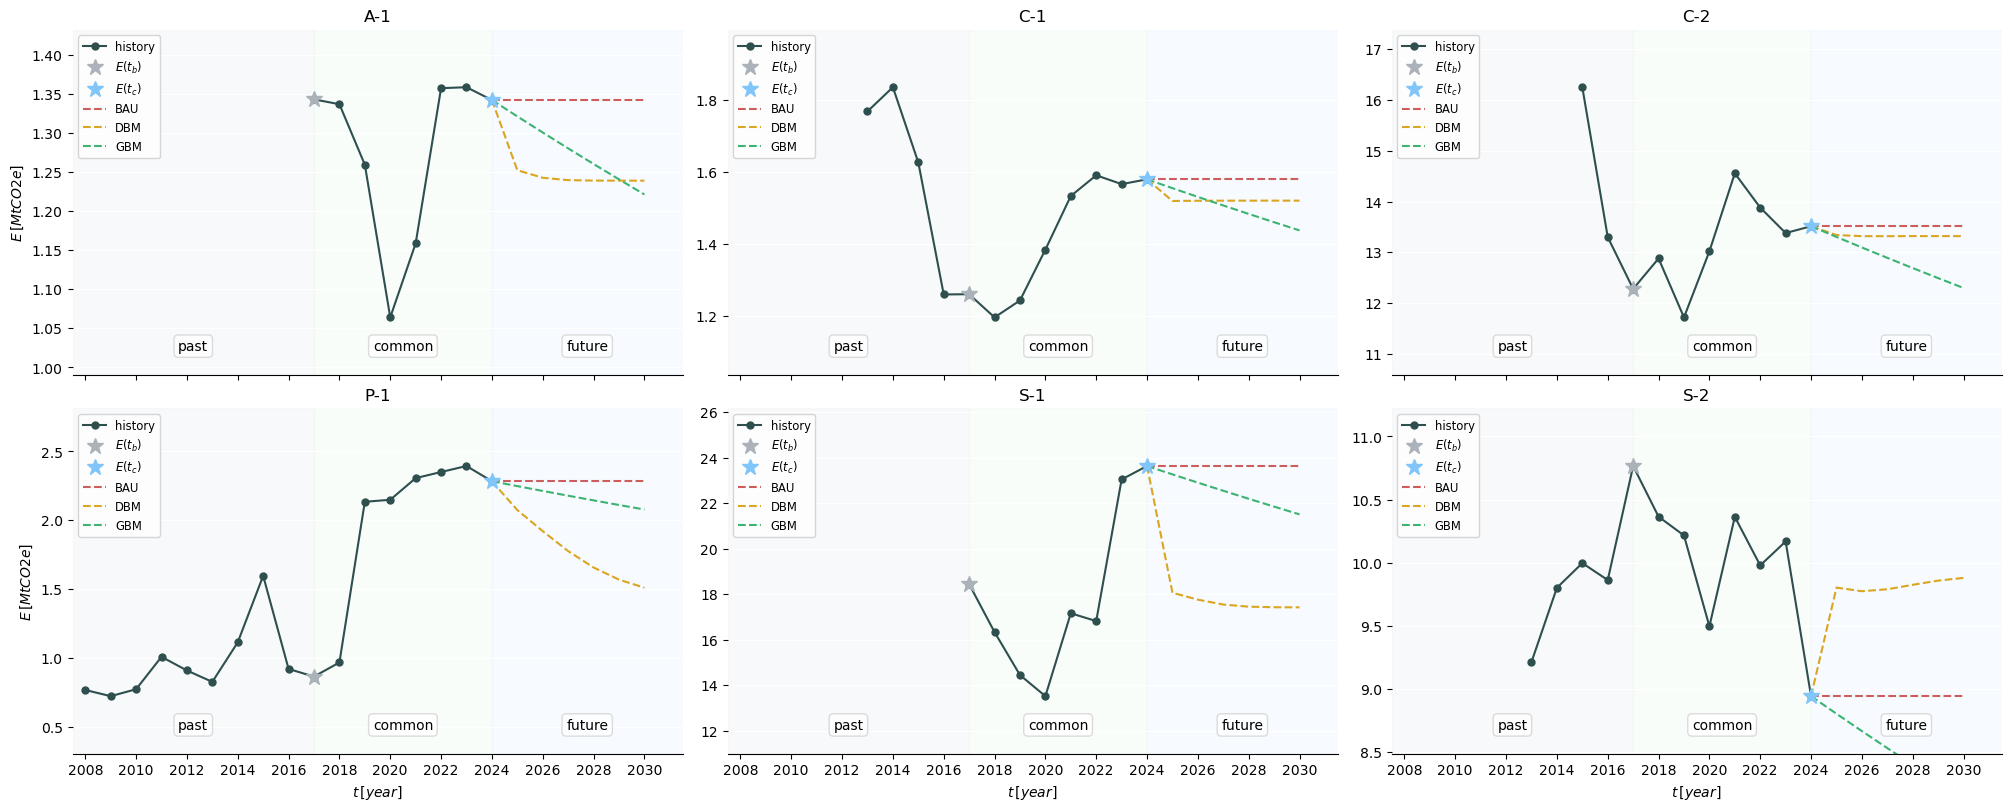

In [5]:
# Training Parameters (SVR)

k = 0.01
weighting_params = set_weight_dict("sigmoid", k)

# Preparing Variable for Data Export
output = dict()

# Plots

colors = {
    "History": mcolors.CSS4_COLORS["darkslategray"],
    "Reference": mcolors.CSS4_COLORS["mediumturquoise"],
    "DBM": mcolors.CSS4_COLORS["goldenrod"],
    "GBM": mcolors.CSS4_COLORS["mediumseagreen"],
    "BAU": mcolors.CSS4_COLORS["indianred"],
}

# Start Plot

fig, axs = plt.subplots(2, 3, figsize=(20, 8), constrained_layout=True, sharex=True)
axs = axs.flatten()

for company_id, company_name in enumerate(list_of_companies):
    # Data Processing for Training
    data = get_values(df, company_name, commom_range, future_range)
    X_hist, y_hist, X_filt, y_filt, X_pred, X_plot = data
    output["Years"] = X_pred.tolist()

    commom_range_delimiter = np.where(X_hist == commom_range[0])[0][0]

    # Plot (History)
    ax = axs[company_id]
    ax.plot(
        X_hist, y_hist, "-o", color=colors["History"], ms=5, label="history", zorder=10
    )
    ax.plot(
        X_filt[0], y_filt[0], "*", color="#abb2b9", ms=12, label="$E(t_b)$", zorder=11
    )
    ax.plot(
        X_hist[-1],
        y_hist[-1],
        "*",
        color="#80c6fa",
        ms=12,
        label="$E(t_c)$",
        zorder=12,
    )

    # BAU
    y_pred = applies_constant_line(y_hist, X_pred)
    y_plot = np.insert(y_pred, 0, y_hist[-1])
    output[f"{company_name} - BAU"] = y_pred.tolist()

    ax.plot(X_plot, y_plot, "--", color=colors["BAU"], label="BAU")

    # DBM
    y_pred = fit_model(
        X_hist,
        y_hist,
        "svr-rbf",
        weighting_params,
        commom_range_delimiter,
        C=best_param_by_company[company_name][1],
        epsilon=best_param_by_company[company_name][2],
    ).predict(X_pred.reshape(-1, 1))
    y_plot = np.insert(y_pred, 0, y_hist[-1])
    output[f"{company_name} - DBM"] = y_pred.tolist()

    ax.plot(X_plot, y_plot, "--", color=colors["DBM"], label="DBM")

    # GBM
    y_pred = applies_power_law(X_hist, y_hist, X_pred)
    y_plot = np.insert(y_pred, 0, y_hist[-1])
    output[f"{company_name} - GBM"] = y_pred.tolist()

    ax.plot(X_plot, y_plot, "--", color=colors["GBM"], label="GBM")

    # Configure Plot
    y_baseline = config_plot(
        ax,
        y_hist,
        x_lim=[past_range[0] - 0.5, future_range[1] + 0.5],
        title=f"{company_name}",
        leg_loc="upper left",
    )

    if company_id in [0, 3]:
        ax.set_ylabel("$E \\, [MtCO2e]$")

    if company_id >= 3:
        ax.set_xlabel("$t \\, [year]$")

    add_axvspan_annotation(
        ax, past_range[0] - 0.5, past_range[1], y_baseline=y_baseline
    )
    add_axvspan_annotation(ax, commom_range[0], commom_range[1], y_baseline=y_baseline)
    add_axvspan_annotation(
        ax, commom_range[1], future_range[1] + 0.5, y_baseline=y_baseline
    )

fig.savefig(f"../img/Forecast.png", dpi=600, bbox_inches="tight")

### Export Values

In [6]:
e = pd.DataFrame(output)
display(e)

e.to_csv("../data/Forecast (MtCO2e).csv")
e.to_excel("../data/Forecast (MtCO2e).xlsx")

,Years,A-1 - BAU,A-1 - DBM,A-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,S-1 - BAU,S-1 - DBM,S-1 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM
0,2025,1.341908,1.252185,1.320980,1.579306,1.519020,1.554676,13.513428,13.340975,13.302679,2.283988,2.074743,2.248368,23.632865,18.060261,23.264298,8.940516,9.801581,8.801084
1,2026,1.341908,1.242492,1.300379,1.579306,1.519730,1.530430,13.513428,13.317894,13.095216,2.283988,1.921093,2.213303,23.632865,17.756772,22.901478,8.940516,9.772826,8.663826
2,2027,1.341908,1.239475,1.280099,1.579306,1.519925,1.506562,13.513428,13.317618,12.890989,2.283988,1.776351,2.178785,23.632865,17.540634,22.544317,8.940516,9.788235,8.528709
3,2028,1.341908,1.238880,1.260135,1.579306,1.519972,1.483066,13.513428,13.319519,12.689947,2.283988,1.657053,2.144806,23.632865,17.448469,22.192726,8.940516,9.823698,8.395699
4,2029,1.341908,1.238803,1.240482,1.579306,1.519983,1.459937,13.513428,13.319376,12.492040,2.283988,1.569028,2.111357,23.632865,17.423024,21.846618,8.940516,9.856964,8.264763
5,2030,1.341908,1.238796,1.221136,1.579306,1.519985,1.437168,13.513428,13.318683,12.297220,2.283988,1.510201,2.078429,23.632865,17.418340,21.505907,8.940516,9.878516,8.135870


# Petrobras Emissions Data Analysis

### Imports

In [7]:
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit

### Data Reading

In [8]:
URL = "https://raw.githubusercontent.com/thiagoneye/project-ccus_analysis/main/data/Relat%C3%B3rio%20de%20Emiss%C3%B5es%20da%20Petrobras.xlsx"
response = requests.get(URL)
br = pd.read_excel(BytesIO(response.content), engine="openpyxl", skiprows=1)

# 2023 emissions only
E_2023 = df.iloc[-2]
E_2023 = E_2023.to_dict()

# History
th, Eh = br["Ano"].values, br["milhões de toneladas"].values

KeyError: 'Ano'

### Whole-History Fit

- Best R2 score through polynomial fit for whole history data was found to be at maximum 5 degree (before poor conditioning) but 4-degree responds well

In [ ]:
c = np.polyfit(th, Eh, deg=4)
poly = np.poly1d(c)
E_ = poly(th)
R2h = r2_score(Eh, E_)
print(f"R2 score (history fit) = {R2h:.2f}")

### Exponential Decay Fit

- Notice that from 2014 onward, the emissions decreased monotonically
- Then, we'll use a exp decay fit to get the _mitigation rate_ only from the common window span for benchmarking purposes

In [ ]:
# Common Window Start
tb = 2017

# Fit Model
def exp_decay(t, a, alpha):
    return a * np.exp(alpha * (t - tb))


# Common Window Span
cutoff = np.where(th == tb)[0].item()
th_e = th[cutoff:]
Eh_e = Eh[cutoff:]

# Fit
params, _ = curve_fit(exp_decay, th_e, Eh_e, method="lm")

# Mitigation Rate
ALPHA = params[1]

# Extract Fitted Parameters
print(f"Mitigation rate: {ALPHA:.3f}")

# Evaluate Fit
E_e = exp_decay(th_e, *params)
r2_e = r2_score(Eh_e, E_e)
print(f"R2 score (common window fit): {r2_e:.2f}")

In [ ]:
# Lambda Functions

f_k = lambda E_k, T, t: E_k * np.exp(
    np.log(0.91) / (2030 - T) * (t - T)
)  # Decay Model (GBM)
f_br = lambda E_k, T, t: E_k * np.exp(ALPHA * (t - T))  # Benchmark (Petrobras)

# Functions


def lag_cumulative(comp, br, opt="cum"):
    if opt == "cum":
        print(
            f"Cumulative emission lag = {np.cumsum(comp)[-1] - np.cumsum(br)[-1]:.3f} tCO2e"
        )

    elif opt == "2030":
        print(f"Emission lag only at 2030 = {comp[-1] - br[-1]:.3f} tCO2e\n")

### Plotting

In [ ]:
# Inputs

tc = 2024  # Beginning of the Future Domain
tf = np.arange(tc, 2030 + 1)  # Future Domain


def plot_future(a, Fk, Fbr):
    ax[a].plot(tf, Fk, label=comp)
    ax[a].plot(tf, Fbr, ls="--", label=comp + " (alpha)")


# Plots

fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharey=False, constrained_layout=True)
ax = ax.flatten()

# Curve Fitting
ax[0].plot(th, Eh, "-o", color=colors["History"], ms=5, label="history", zorder=2)
ax[0].plot(th, E_, label="polyfit(4)", lw=0.75, ls=":", color="gray")
ax[0].plot(
    th_e,
    E_e,
    color=mcolors.CSS4_COLORS["darkviolet"],
    ls="--",
    label=f"EDF: alpha = {ALPHA:.2f}",
)
# ax[0].axvline(x=2015, ls=":", lw=1, c="blue")  # Beginning of the Common Domain

# Benchmark
for comp, E_k in E_2023.items():
    Fk = f_k(E_k, tc, tf)
    Fbr = f_br(E_k, tc, tf)

    if comp in ["Years", "ISA Energia"]:
        continue
    elif comp in ["C-1", "A-1", "P-1"]:
        plot_future(1, Fk, Fbr)
        lag_cumulative(Fk, Fbr, opt="cum")
        # lag_cumulative(Fk, Fbr, opt="2030")
    elif comp in ["C-2", "S-2"]:
        plot_future(2, Fk, Fbr)
        lag_cumulative(Fk, Fbr, opt="cum")
        # lag_cumulative(Fk, Fbr, opt="2030")
    else:
        plot_future(3, Fk, Fbr)
        lag_cumulative(Fk, Fbr, opt="cum")
        # lag_cumulative(Fk, Fbr, opt="2030")

# Configure Plot

ax[0].xaxis.set_major_locator(MultipleLocator(3))
ax[0].set_xlim([min(th) - 0.5, commom_range[1] + 0.5])

y_min, y_max = min(Eh), max(Eh)
y_min_lim, y_max_lim = get_ylim(y_min, y_max)
y_baseline = np.mean([y_min, y_min_lim])
ax[0].set_ylim([y_min_lim, y_max_lim])

add_axvspan_annotation(ax[0], min(th) - 0.5, past_range[1], y_baseline=y_baseline)
add_axvspan_annotation(ax[0], commom_range[0], commom_range[1] + 0.5, y_baseline=y_baseline)

ax[0].grid(color="w", axis="y")
ax[0].legend(loc="upper right", fontsize=8)
ax[0].legend(
    ncols=3, fontsize=6, loc="upper center", bbox_to_anchor=(0.5, -0.25), frameon=False
)
ax[0].set_xlabel("$t \\, [year]$")
ax[0].set_ylabel("$E \\, [MtCO2e]$")

ax[1].xaxis.set_major_locator(MultipleLocator(2))
ax[1].set_title("")
# ax[1].legend(ncols=3, fontsize=6, bbox_to_anchor=(0.95, 1.2))
ax[1].legend(
    ncols=3, fontsize=6, loc="upper center", bbox_to_anchor=(0.5, -0.25), frameon=False
)
ax[1].set_xlabel("$t \\, [year]$")

ax[2].xaxis.set_major_locator(MultipleLocator(2))
ax[2].set_title("")
ax[2].legend(
    ncols=2, fontsize=6, loc="upper center", bbox_to_anchor=(0.5, -0.25), frameon=False
)
ax[2].set_xlabel("$t \\, [year]$")

ax[3].xaxis.set_major_locator(MultipleLocator(2))
ax[3].set_title("")
ax[3].legend(
    ncols=2, fontsize=6, loc="upper center", bbox_to_anchor=(0.5, -0.25), frameon=False
)
ax[3].set_xlabel("$t \\, [year]$")

# Create Extra Space Below to Fit Subtitles
fig.subplots_adjust(bottom=0.5)

# Set the Title
fig.suptitle("Exponential Decay Fit", fontsize=14, y=1.15)

# Save Figure
fig.savefig(f"../img/Benchmark.png", dpi=600, bbox_inches="tight")

# Capital Cost of Compression

In [ ]:
# Auxiliary Functions


def compression_power_stage(cp, z, m, r, t_in, M, eta_is, k, cr):
    """
    Compression Power Requirement - for each stage
    """

    # Relationship between Specific Heat (Coefficient of Adiabatic Expansion. i.e.. Cp/Cv)
    k = cp / z

    w_stage = (
        (1000 / (24 * 3600))
        * (m * z * r * t_in / (M * eta_is))
        * (k / (k - 1))
        * (cr ** (((k - 1) / k)) - 1)
    )

    return w_stage

def power_requeriment(df):
    return df

In [ ]:
# Variables

p_initial = 0.1  # MPa
p_final = 15  # MPa
p_cutoff = 7.38  # MPa
n_stage = 4
M = 44.01  # kg/kmol
r = 8.314  # [kJ/kmol*K]
t_in = 313.15  # K
eta_is = 0.82
m = 25000
rho = 630
np = 0.75

dt = 356  # Temperature Variation During Compression

cv = (
    (
        22.26
        + ((5.981 * 10**-2) * dt)
        + ((-3.501 * 10**-5) * dt**2)
        + ((7.469 * 10**-9) * dt**3)
    )
    / 44.01
) - (
    8.314 / 44.01
)  # 0.707

cp = (
    (
        22.26
        + ((5.981 * 10**-2) * dt)
        + ((-3.501 * 10**-5) * dt**2)
        + ((7.469 * 10**-9) * dt**3)
    )
    / 44.01
) / cv  # 1.267


# Compression Power Requirement (for each stage)

cr = (p_cutoff / p_initial) ** (1 / n_stage)

z = 0.995  # Compression Ratio
w_stage1 = compression_power_stage(cp, z, m, r, t_in, M, eta_is, k, cr)

z = 0.986
w_stage2 = compression_power_stage(cp, z, m, r, t_in, M, eta_is, k, cr)

z = 0.959
w_stage3 = compression_power_stage(cp, z, m, r, t_in, M, eta_is, k, cr)

z = 0.875
w_stage4 = compression_power_stage(cp, z, m, r, t_in, M, eta_is, k, cr)

In [ ]:
# Convertion to tCO2e

e.loc[:, e.columns != "Years"] = e.loc[:, e.columns != "Years"] * 1e6
display(e)

# Carbon Capture Percentage

e.loc[:, e.columns != "Years"] = e.loc[:, e.columns != "Years"] * 0.76

# Power Requirement [kW]

# Plot

# Capital Cost of Compression ($)

# Capital Cost of Compression ($/kW)

# Plot

# Annual Compression Capital Cost ($)

# Total Annual Compression Cost ($)

# Plot
